# 1. Import Libraries

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import yfinance as yf
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.arima.model import ARIMA
from arch import arch_model


**For display and styling**

In [2]:
sns.set(style="whitegrid")

# 2. Download Data

In [4]:
# 2. Download Data
tsla = yf.download("TSLA", start="2018-01-01", end="2024-12-31")
tsla = tsla[["Close"]]
tsla.rename(columns={"Close": "Price"}, inplace=True)
tsla.dropna(inplace=True)

[*********************100%***********************]  1 of 1 completed


# 3. Visualize Time Series

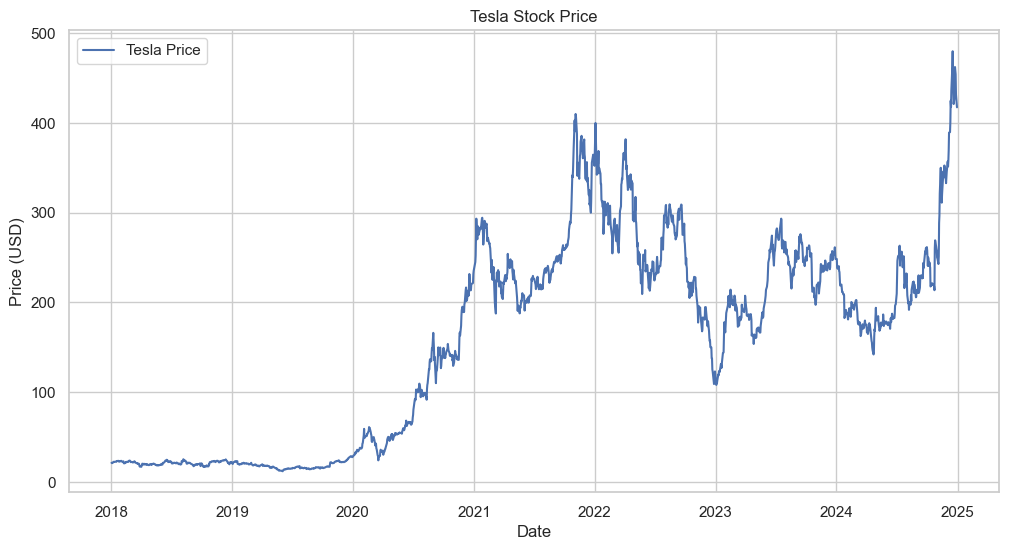

In [5]:
plt.figure(figsize=(12, 6))
plt.plot(tsla["Price"], label="Tesla Price")
plt.title("Tesla Stock Price")
plt.xlabel("Date")
plt.ylabel("Price (USD)")
plt.legend()
plt.show()


# 4. Check Stationarity

In [6]:
result = adfuller(tsla["Price"])
print("ADF Statistic:", result[0])
print("p-value:", result[1])


ADF Statistic: -1.0558800774802823
p-value: 0.7323420957744895


**ADF Test Result (Original Series):**
- ADF Statistic: -1.056
- p-value: 0.732

The Augmented Dickey-Fuller (ADF) test is used to check the stationarity of a time series. The null hypothesis (H₀) is that the series has a unit root (i.e., it is non-stationary).

Since the p-value (0.732) is much greater than the significance level (commonly 0.05), we **fail to reject the null hypothesis**. This means that the original Tesla stock price series is **non-stationary** and not suitable for ARIMA modeling in its current form.

We therefore apply differencing to achieve stationarity.


In [7]:
returns = tsla["Price"].pct_change().dropna()
tsla_diff = tsla["Price"].diff().dropna()


**Recheck stationarity on differenced data**

In [8]:
result_diff = adfuller(tsla_diff)
print("\nDifferenced ADF Statistic:", result_diff[0])
print("p-value:", result_diff[1])



Differenced ADF Statistic: -7.465923674126346
p-value: 5.204980864957356e-11


**ADF Test Result (After First Differencing):**
- ADF Statistic: -7.466
- p-value: 5.20e-11

After differencing the Tesla stock price series once, the Augmented Dickey-Fuller (ADF) test shows a very low p-value (essentially zero), which is well below the 0.05 significance threshold.

This means we **reject the null hypothesis** and conclude that the **differenced series is stationary**.


# 5. Plot ACF and PACF

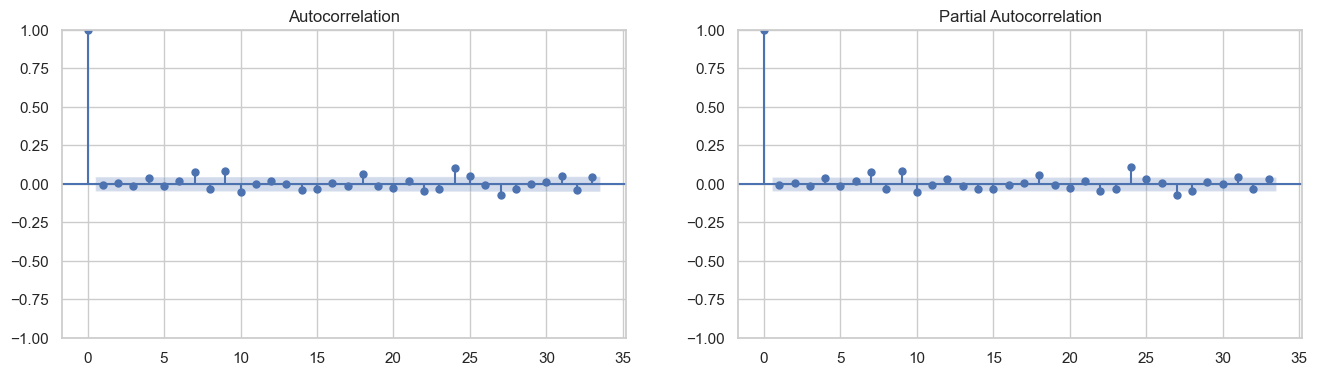

In [9]:
fig, ax = plt.subplots(1, 2, figsize=(16, 4))
plot_acf(tsla_diff, ax=ax[0])
plot_pacf(tsla_diff, ax=ax[1])
plt.show()


# 6. Fit ARIMA Model
Based on ACF and PACF plots:
 - ACF cuts off after lag 1 → suggests q = 0
 - PACF has significant spike at lag 1 → suggests p = 1
Hence, ARIMA(1,1,0) is chose

In [10]:
model_arima = ARIMA(tsla["Price"], order=(1,1,0))
model_fit_arima = model_arima.fit()
print(model_fit_arima.summary())

c:\Users\MK\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\MK\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\MK\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


                               SARIMAX Results                                
Dep. Variable:                   TSLA   No. Observations:                 1760
Model:                 ARIMA(1, 1, 0)   Log Likelihood               -6034.934
Date:                Tue, 22 Apr 2025   AIC                          12073.868
Time:                        16:38:11   BIC                          12084.813
Sample:                             0   HQIC                         12077.913
                               - 1760                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.0082      0.017     -0.480      0.631      -0.042       0.025
sigma2        55.9188      0.915     61.110      0.000      54.125      57.712
Ljung-Box (L1) (Q):                   0.00   Jarque-

**Forecast**

c:\Users\MK\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
c:\Users\MK\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:837: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(


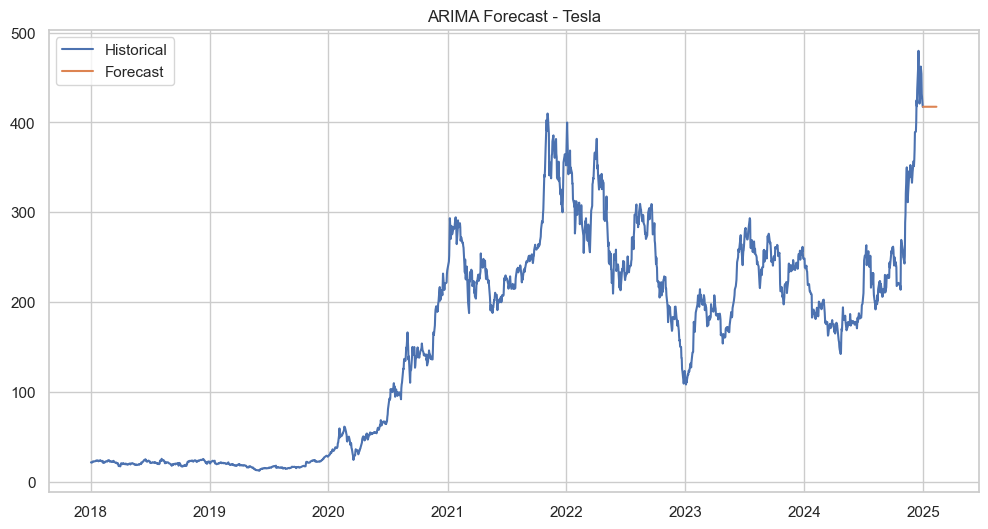

In [11]:
forecast_steps = 30
forecast = model_fit_arima.forecast(steps=forecast_steps)

plt.figure(figsize=(12, 6))
plt.plot(tsla["Price"], label="Historical")
plt.plot(pd.date_range(tsla.index[-1], periods=forecast_steps+1, freq='B')[1:], forecast, label="Forecast")
plt.title("ARIMA Forecast - Tesla")
plt.legend()
plt.show()

# 7. GARCH Modeling
 **Use returns for GARCH**

In [12]:
am = arch_model(returns * 100, vol='Garch', p=1, q=1)
res = am.fit(update_freq=5)
print(res.summary())

Iteration:      5,   Func. Count:     31,   Neg. LLF: 4891.628697213006
Iteration:     10,   Func. Count:     62,   Neg. LLF: 4871.53048605962
Optimization terminated successfully    (Exit mode 0)
            Current function value: 4871.522458249257
            Iterations: 14
            Function evaluations: 81
            Gradient evaluations: 14
                     Constant Mean - GARCH Model Results                      
Dep. Variable:                   TSLA   R-squared:                       0.000
Mean Model:             Constant Mean   Adj. R-squared:                  0.000
Vol Model:                      GARCH   Log-Likelihood:               -4871.52
Distribution:                  Normal   AIC:                           9751.04
Method:            Maximum Likelihood   BIC:                           9772.93
                                        No. Observations:                 1759
Date:                Tue, Apr 22 2025   Df Residuals:                     1758
Time:           

**Plot volatility**

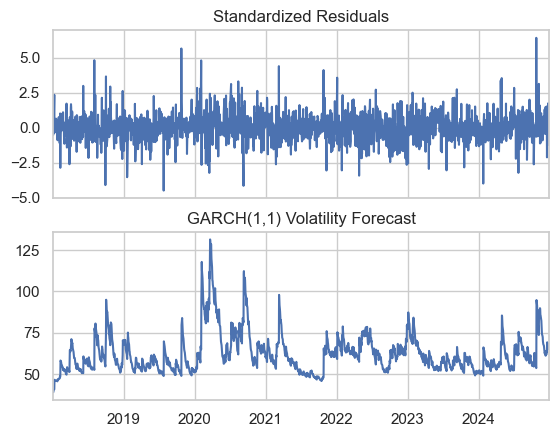

In [13]:
fig = res.plot(annualize='D')
plt.title("GARCH(1,1) Volatility Forecast")
plt.show()